In [ ]:
%matplotlib inline


# Neural Transfer Using PyTorch






## Importing Packages
Below is a  list of the packages needed to implement the neural transfer.

-  ``torch``, ``torch.nn``, ``numpy`` (indispensables packages for
   neural networks with PyTorch)
-  ``torch.optim`` (efficient gradient descents)
-  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (load and display
   images)
-  ``torchvision.transforms`` (transform PIL images into tensors)
-  ``torchvision.models`` (train or load pre-trained models)
-  ``copy`` (to deep copy the models; system package)



In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import time
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
cd /content/drive/Shareddrives/581_final_project/CIS581_Final\ Project_Yifan\ and\ Zilin

/content/drive/Shareddrives/581_final_project/CIS581_Final Project_Yifan and Zilin


## Loading the Images

We have images from Content folder and style folder. They will be processed to 1024x1024 if using GPU or 128x128 if using CPU.



In [14]:
# desired size of the output image
imsize = 1024 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./image/style/van_gogh_starry_night.jpg")
# style_img = image_loader("./image/style/picasso_self_portrait.jpg")
# style_img = image_loader("./image/style/derain_mountains_at_colloiure.jpg")

# style_img = image_loader("./image/style/picasso.jpg")
# content_img = image_loader("./image/content/dancing.jpg")
content_img = image_loader("./image/content/penn.jpeg")


assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Show the image


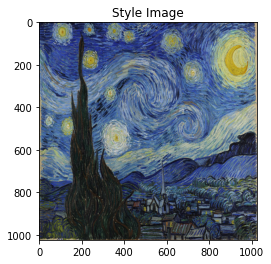

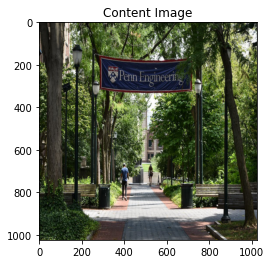

In [15]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss Functions
Content Loss





In [16]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

Style Loss





In [17]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [18]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        # self.target = target_feature

    def forward(self, input):
        G = gram_matrix(input)
        # G = input
        self.loss = F.mse_loss(G, self.target)
        return input

## Importing the Model

We use VGG-19 as the base network.




In [19]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




In [20]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [21]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []
    temporal_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, style_losses, content_losses



## Load input image



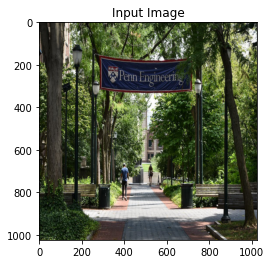

In [30]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

## Gradient Descent with different loss functions



In [23]:
import torch, time, gc

# Timing utilities
start_time = None

def start_timer():
    global start_time
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()
    start_time = time.time()

def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time.time()
    print("\n" + local_msg)
    print("Total execution time = {:.3f} sec".format(end_time - start_time))
    print("Max memory used by tensors = {} bytes".format(torch.cuda.max_memory_allocated()))

### LBFGS

In [24]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [25]:
#LBFGS
def run_lbfgs(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    start_timer()
    while run[0] <= num_steps:
        
        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)
    end_timer_and_print("Default precision:")
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


<ipython-input-20-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-20-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..


/usr/local/lib/python3.8/dist-packages/torch/cuda/memory.py:282: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


run [50]:
Style Loss : 55.397175 Content Loss: 20.395039

run [100]:
Style Loss : 7.190936 Content Loss: 15.711374

run [150]:
Style Loss : 2.980047 Content Loss: 11.683270

run [200]:
Style Loss : 2.046126 Content Loss: 9.702847

run [250]:
Style Loss : 1.539007 Content Loss: 8.658662

run [300]:
Style Loss : 1.180030 Content Loss: 8.035740

run [350]:
Style Loss : 0.927523 Content Loss: 7.671626

run [400]:
Style Loss : 0.759160 Content Loss: 7.448596

run [450]:
Style Loss : 0.638957 Content Loss: 7.289419

run [500]:
Style Loss : 0.563690 Content Loss: 7.165054


Default precision:
Total execution time = 112.855 sec
Max memory used by tensors = 5206599168 bytes


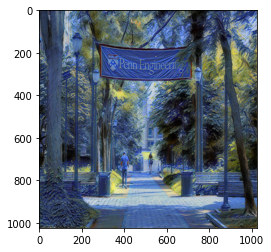

In [26]:
output1 = run_lbfgs(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
imshow(output1)

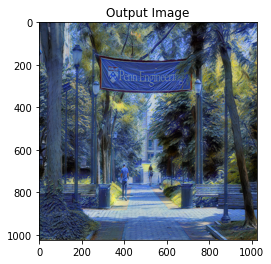

In [27]:
from torchvision.utils import save_image
plt.figure()
# print(output)
imshow(output1, title='Output Image')

plt.ioff()
save_image(output1, 'penn_output.png')
plt.show()

### SGD

In [28]:
#SGD
def run_sgd(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = optim.SGD([input_img], lr=0.1, momentum=0.9)
    # optimizer = optim.Adam([input_img], lr=10)
    # optimizer = get_input_optimizer(input_img)

    # AMP usage
    use_amp = True
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    print('Optimizing..')
    run = [0]
    style_loss, content_loss = 0, 0

    start_timer()
    while run[0] <= num_steps:

        # correct the values of updated input image
        with torch.no_grad():
            input_img.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        if run[0] % 50 == 0:
            style_loss = style_score.item()
            content_loss = content_score.item()
            print("run {}:".format(run))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
                
            print()
          
        loss.backward()

        run[0] += 1

        optimizer.step()


    end_timer_and_print("Default precision:")
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


<ipython-input-20-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-20-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [0]:
Style Loss : 1117.520020 Content Loss: 0.000000

run [50]:
Style Loss : 71.543816 Content Loss: 15.019402

run [100]:
Style Loss : 33.165073 Content Loss: 12.801620

run [150]:
Style Loss : 16.906212 Content Loss: 11.294935

run [200]:
Style Loss : 10.457437 Content Loss: 10.268616

run [250]:
Style Loss : 7.704526 Content Loss: 9.537502

run [300]:
Style Loss : 6.311479 Content Loss: 8.998545

run [350]:
Style Loss : 5.457492 Content Loss: 8.587542

run [400]:
Style Loss : 4.849411 Content Loss: 8.266512

run [450]:
Style Loss : 4.376883 Content Loss: 8.009981

run [500]:
Style Loss : 3.992112 Content Loss: 7.800774


Default precision:
Total execution time = 87.504 sec
Max memory used by tensors = 4939338240 bytes


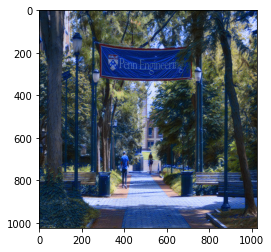

In [31]:
output = run_sgd(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
imshow(output)

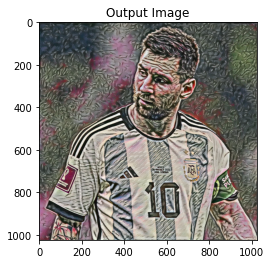

In [ ]:
from torchvision.utils import save_image
plt.figure()
# print(output)
imshow(output1, title='Output Image')

plt.ioff()
save_image(output1, 'sucessful.png')
plt.show()


### ADAM

In [ ]:

def run_adam(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    # optimizer = optim.SGD([input_img], lr=0.1, momentum=0.9)
    optimizer = optim.Adam([input_img], lr=0.1)
    # optimizer = get_input_optimizer(input_img)

    # AMP usage
    use_amp = True
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    print('Optimizing..')
    run = [0]
    style_loss, content_loss = 0, 0

    start_timer()
    while run[0] <= num_steps:

        # correct the values of updated input image
        with torch.no_grad():
            input_img.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        if run[0] % 50 == 0:
            style_loss = style_score.item()
            content_loss = content_score.item()
            print("run {}:".format(run))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()
          
        loss.backward()

        run[0] += 1

        optimizer.step()


    end_timer_and_print("Default precision:")
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [0]:
Style Loss : 1926.076538 Content Loss: 0.000000



<ipython-input-14-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 143.066010 Content Loss: 24.251205

run [100]:
Style Loss : 27.994602 Content Loss: 22.574543

run [150]:
Style Loss : 5.792986 Content Loss: 20.908966

run [200]:
Style Loss : 2.944463 Content Loss: 19.495811

run [250]:
Style Loss : 2.179604 Content Loss: 18.427698

run [300]:
Style Loss : 1.806519 Content Loss: 17.617388

run [350]:
Style Loss : 1.579274 Content Loss: 16.977177

run [400]:
Style Loss : 1.425769 Content Loss: 16.456848

run [450]:
Style Loss : 1.314788 Content Loss: 16.026569

run [500]:
Style Loss : 1.230716 Content Loss: 15.666508


Default precision:
Total execution time = 23.876 sec
Max memory used by tensors = 808571904 bytes


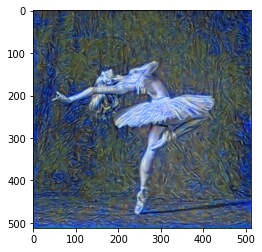

In [ ]:
output = run_adam(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
imshow(output)

# Experiment of Optimizers

Run each experiment 50 times and calculate the average loss at the end of each round.

## SGD

### Normal SGD

In [ ]:
#SGD
def run_sgd(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = optim.SGD([input_img], lr=0.1, momentum=0.9)
    # optimizer = optim.Adam([input_img], lr=10)
    # optimizer = get_input_optimizer(input_img)

    # AMP usage
    use_amp = True
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    print('Optimizing..')
    run = [0]
    style_loss, content_loss = 0, 0

    start_timer()
    while run[0] <= num_steps:

        # correct the values of updated input image
        with torch.no_grad():
            input_img.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        if run[0] % 50 == 0:
            style_loss = style_score.item()
            content_loss = content_score.item()
            print("run {}:".format(run))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
                
            print()
          
        loss.backward()

        run[0] += 1

        optimizer.step()


    end_timer_and_print("Default precision:")
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img, style_loss, content_loss

Building the style transfer model..
Optimizing..
run [0]:
Style Loss : 1926.076538 Content Loss: 0.000000



<ipython-input-14-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
/usr/local/lib/python3.8/dist-packages/torch/cuda/memory.py:282: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


run [50]:
Style Loss : 17.368721 Content Loss: 21.432833

run [100]:
Style Loss : 2.899467 Content Loss: 18.592720

run [150]:
Style Loss : 2.194248 Content Loss: 17.253933

run [200]:
Style Loss : 1.879410 Content Loss: 16.492029

run [250]:
Style Loss : 1.681224 Content Loss: 15.976341

run [300]:
Style Loss : 1.541143 Content Loss: 15.598074

run [350]:
Style Loss : 1.435003 Content Loss: 15.307812

run [400]:
Style Loss : 1.352502 Content Loss: 15.075989

run [450]:
Style Loss : 1.285437 Content Loss: 14.887459

run [500]:
Style Loss : 1.230609 Content Loss: 14.729465


Default precision:
Total execution time = 21.480 sec
Max memory used by tensors = 799135744 bytes
final style loss: 1.2306088209152222, final content_loss : 14.729464530944824


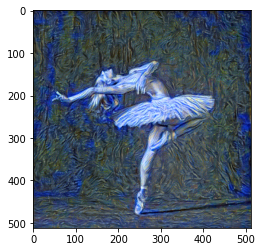

In [ ]:
output, style_loss, content_loss = run_sgd(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

print(f'final style loss: {style_loss}, final content_loss : {content_loss}')
imshow(output)

### SGD with AMP

Not able to converge!

In [ ]:
#LBFGS with AMP
def run_sgd_AMP(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=10, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = optim.SGD([input_img], lr=0.1, momentum=0.9)
    # optimizer = optim.Adam([input_img], lr=10)
    # optimizer = get_input_optimizer(input_img)

    # AMP usage
    use_amp = True
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    print('Optimizing..')
    run = 0
    style_loss, content_loss = 0, 0
    start_timer()
    while run <= num_steps:

        # correct the values of updated input image
        with torch.no_grad():
            input_img.clamp_(0, 1)
        with torch.autocast(device_type='cuda', dtype=torch.float16):        
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            if run % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
          

        scaler.scale(loss).backward()
        # loss.backward(）

        # scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        scaler.step(optimizer)
        # optimizer.step(closure)
        scaler.update()
        run += 1


    end_timer_and_print("SGD AMP precision:")
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run 0:
Style Loss :  inf Content Loss: 0.000052



<ipython-input-14-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run 50:
Style Loss :  inf Content Loss: 0.000052

run 100:
Style Loss :  inf Content Loss: 0.000052

run 150:
Style Loss :  inf Content Loss: 0.000052

run 200:
Style Loss :  inf Content Loss: 0.000052

run 250:
Style Loss :  inf Content Loss: 0.000052

run 300:
Style Loss :  inf Content Loss: 0.000052

run 350:
Style Loss :  inf Content Loss: 0.000052

run 400:
Style Loss :  inf Content Loss: 0.000052

run 450:
Style Loss :  inf Content Loss: 0.000052

run 500:
Style Loss :  inf Content Loss: 0.000052


SGD AMP precision:
Total execution time = 10.687 sec
Max memory used by tensors = 573230592 bytes


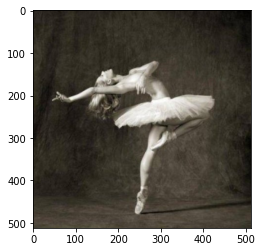

In [ ]:
output = run_sgd_AMP(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
imshow(output)

### Run SGD 50 times and take average final loss

Average style loss: 2.032984561920166

Average content loss: 17.65688606262207

In [ ]:
style_losses, content_losses = [], []
for e in range(50):
  print(f'round: {e}')
  original_input = image_loader("frame0.jpg")
  _, style_loss, content_loss = run_sgd(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, original_input)
  print(style_loss, content_loss)
  style_losses.append(style_loss)
  content_losses.append(content_loss)

print(f'Average style loss: {sum(style_losses)/len(style_losses)}, Average content loss: {sum(content_losses)/len(content_losses)}')

Building the style transfer model..
Optimizing..
run [0]:
Style Loss : 1519.420898 Content Loss: 13.795948



<ipython-input-14-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 8.473843 Content Loss: 27.032284

run [100]:
Style Loss : 4.835755 Content Loss: 23.758656

run [150]:
Style Loss : 4.000181 Content Loss: 22.072739

run [200]:
Style Loss : 3.483239 Content Loss: 20.945282

run [250]:
Style Loss : 3.102581 Content Loss: 20.101706

run [300]:
Style Loss : 2.802430 Content Loss: 19.427956

run [350]:
Style Loss : 2.557906 Content Loss: 18.870584

run [400]:
Style Loss : 2.353256 Content Loss: 18.402008

run [450]:
Style Loss : 2.180208 Content Loss: 18.001972

run [500]:
Style Loss : 2.032349 Content Loss: 17.656464


Default precision:
Total execution time = 22.048 sec
Max memory used by tensors = 805427200 bytes
2.032349109649658 17.656463623046875
Building the style transfer model..
Optimizing..
run [0]:
Style Loss : 1519.420898 Content Loss: 13.795948

run [50]:
Style Loss : 8.474007 Content Loss: 27.028515

run [100]:
Style Loss : 4.835169 Content Loss: 23.752029

run [150]:
Style Loss : 3.999507 Content Loss: 22.066925

run 

## LBFGS
Run 50 times and take average final loss:

Average style loss: 2.4850511264801027

Average content loss: 19.937194023132324

In [ ]:
def run_lbfgs(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)
    # optimizer = optim.SGD([input_img], lr=0.001, momentum=0.9)
    # optimizer = optim.Adam([input_img], lr=1e-5)
    

    print('Optimizing..')
    run = [0]
    style_L = []
    content_L = []
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
            if run[0] == 300:
              style_L.append(style_score.item())
              content_L.append(content_score.item())

            return style_score + content_score

        optimizer.step(closure)

    # # a last correction...
    # with torch.no_grad():
    #     input_img.clamp_(0, 1)
    return style_L[0], content_L[0]

In [ ]:
style_losses, content_losses = [], []
for e in range(50):
  print(f'round: {e}')
  original_input = image_loader("frame0.jpg")
  style_loss, content_loss = run_lbfgs(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, original_input)
  print(style_loss, content_loss)
  style_losses.append(style_loss)
  content_losses.append(content_loss)

print(f'Average style loss: {sum(style_losses)/len(style_losses)}, Average content loss: {sum(content_losses)/len(content_losses)}')

round: 0
Building the style transfer model..
Optimizing..


<ipython-input-14-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 84.529518 Content Loss: 29.703804
run [100]:
Style Loss : 29.647383 Content Loss: 28.337721
run [150]:
Style Loss : 12.664189 Content Loss: 25.826452
run [200]:
Style Loss : 6.002507 Content Loss: 23.392754
run [250]:
Style Loss : 3.614265 Content Loss: 21.393116
run [300]:
Style Loss : 2.446596 Content Loss: 19.864206
run [350]:
Style Loss : 1.647810 Content Loss: 18.745127
run [400]:
Style Loss : 1.115378 Content Loss: 17.888634
run [450]:
Style Loss : 0.820061 Content Loss: 17.166111
run [500]:
Style Loss : 0.643453 Content Loss: 16.629379
2.4465959072113037 19.864206314086914
round: 1
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 95.787064 Content Loss: 29.668274
run [100]:
Style Loss : 27.904467 Content Loss: 28.070839
run [150]:
Style Loss : 12.344306 Content Loss: 25.779583
run [200]:
Style Loss : 5.882461 Content Loss: 23.355919
run [250]:
Style Loss : 3.719912 Content Loss: 21.481150
run [300]:
Style Loss : 2.435140 Content Loss

## ADAM optimizer

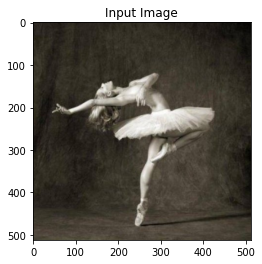

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

### Normal ADAM

Run 50 times and take average final loss: 

Average style loss: 2.4755843925476073

Average content loss: 17.983576278686524


In [ ]:

def run_adam(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    # optimizer = optim.SGD([input_img], lr=0.1, momentum=0.9)
    optimizer = optim.Adam([input_img], lr=0.1)
    # optimizer = get_input_optimizer(input_img)

    # AMP usage
    use_amp = True
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    print('Optimizing..')
    run = [0]
    style_loss, content_loss = 0, 0

    start_timer()
    while run[0] <= num_steps:

        # correct the values of updated input image
        with torch.no_grad():
            input_img.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        if run[0] % 50 == 0:
            style_loss = style_score.item()
            content_loss = content_score.item()
            print("run {}:".format(run))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()
          
        loss.backward()

        run[0] += 1

        optimizer.step()


    end_timer_and_print("Default precision:")
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img, style_loss, content_loss

Building the style transfer model..
Optimizing..
run [0]:
Style Loss : 1926.076538 Content Loss: 0.000000



<ipython-input-14-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 143.066010 Content Loss: 24.251205

run [100]:
Style Loss : 27.994602 Content Loss: 22.574543

run [150]:
Style Loss : 5.792986 Content Loss: 20.908966

run [200]:
Style Loss : 2.944463 Content Loss: 19.495811

run [250]:
Style Loss : 2.179604 Content Loss: 18.427698

run [300]:
Style Loss : 1.806519 Content Loss: 17.617388

run [350]:
Style Loss : 1.579274 Content Loss: 16.977177

run [400]:
Style Loss : 1.425769 Content Loss: 16.456848

run [450]:
Style Loss : 1.314788 Content Loss: 16.026569

run [500]:
Style Loss : 1.230716 Content Loss: 15.666508


Default precision:
Total execution time = 23.876 sec
Max memory used by tensors = 808571904 bytes


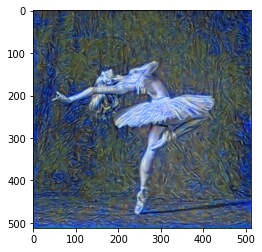

In [ ]:
output, _, _ = run_adam(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
imshow(output)

In [ ]:
style_losses, content_losses = [], []
for e in range(50):
  print(f'round: {e}')
  original_input = image_loader("frame0.jpg")
  _, style_loss, content_loss = run_adam(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, original_input)
  print(style_loss, content_loss)
  style_losses.append(style_loss)
  content_losses.append(content_loss)

print(f'Average style loss: {sum(style_losses)/len(style_losses)}, Average content loss: {sum(content_losses)/len(content_losses)}')

round: 0
Building the style transfer model..
Optimizing..
run [0]:
Style Loss : 1519.420898 Content Loss: 13.795948



<ipython-input-14-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
/usr/local/lib/python3.8/dist-packages/torch/cuda/memory.py:282: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


run [50]:
Style Loss : 51.779243 Content Loss: 28.967339

run [100]:
Style Loss : 10.939312 Content Loss: 26.801617

run [150]:
Style Loss : 7.247074 Content Loss: 24.869081

run [200]:
Style Loss : 5.636542 Content Loss: 23.306477

run [250]:
Style Loss : 4.653408 Content Loss: 22.003443

run [300]:
Style Loss : 3.965422 Content Loss: 20.915459

run [350]:
Style Loss : 3.449777 Content Loss: 19.995934

run [400]:
Style Loss : 3.043034 Content Loss: 19.218132

run [450]:
Style Loss : 2.711885 Content Loss: 18.551695

run [500]:
Style Loss : 2.458883 Content Loss: 18.001902


Default precision:
Total execution time = 22.997 sec
Max memory used by tensors = 812767232 bytes
2.458883047103882 18.001901626586914
round: 1
Building the style transfer model..
Optimizing..
run [0]:
Style Loss : 1519.420898 Content Loss: 13.795948

run [50]:
Style Loss : 51.803928 Content Loss: 28.970364

run [100]:
Style Loss : 10.926920 Content Loss: 26.798792

run [150]:
Style Loss : 7.241927 Content Loss: 24

### ADAM with AMP

Not able to converge

In [ ]:

def run_adam_amp(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    # optimizer = optim.SGD([input_img], lr=0.1, momentum=0.9)
    optimizer = optim.Adam([input_img], lr=0.1)
    # optimizer = get_input_optimizer(input_img)

    # AMP usage
    use_amp = True
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    print('Optimizing..')
    run = [0]

    start_timer()
    while run[0] <= num_steps:

        # correct the values of updated input image
        with torch.no_grad():
            input_img.clamp_(0, 1)
        with torch.autocast(device_type='cuda', dtype=torch.float16):  
            optimizer.zero_grad()
            model(input_img)
        
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        run[0] += 1

    end_timer_and_print("Default precision:")
    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [0]:
Style Loss :  inf Content Loss: 0.000052



<ipython-input-14-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss :  inf Content Loss: 0.000052

run [100]:
Style Loss :  inf Content Loss: 0.000052

run [150]:
Style Loss :  inf Content Loss: 0.000052

run [200]:
Style Loss :  inf Content Loss: 0.000052

run [250]:
Style Loss :  inf Content Loss: 0.000052

run [300]:
Style Loss :  inf Content Loss: 0.000052

run [350]:
Style Loss :  inf Content Loss: 0.000052

run [400]:
Style Loss :  inf Content Loss: 0.000052

run [450]:
Style Loss :  inf Content Loss: 0.000052

run [500]:
Style Loss :  inf Content Loss: 0.000052


Default precision:
Total execution time = 11.072 sec
Max memory used by tensors = 567527424 bytes


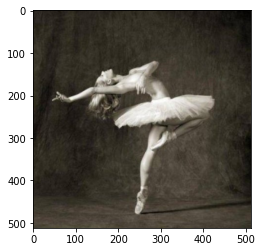

In [ ]:
output = run_adam_amp(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
imshow(output)

# Video Conversion

In [ ]:
# Read in Video
import cv2
import imageio
from torchvision import transforms
import numpy as np

In [ ]:
def preprocess_img(image):
    # fake batch dimension required to fit network's input dimensions
    image = transforms.Resize((imsize, imsize))
    image = transforms.ToTensor()(image)
    return image.to(device, torch.float)

In [ ]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [ ]:
rawVideo = './video/video.mp4'


In [ ]:
cap = cv2.VideoCapture(rawVideo)
imgs = []
frame_cnt = 0
result = []
count = 0
while (cap.isOpened() and count <= 300):
  print(f'round: {count}')
  count += 1
  ret, frame = cap.read()
  cv2.imwrite("frame.jpg", frame)
  if not ret: continue
  content_img = image_loader('frame.jpg')
  input_img = content_img.clone()
  output = run_sgd(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
  result.append(output)


round: 0
Building the style transfer model..


<ipython-input-11-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-11-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [0]:
Style Loss : 1519.420898 Content Loss: 0.000000



/usr/local/lib/python3.8/dist-packages/torch/cuda/memory.py:282: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
round: 176
Building the style transfer model..
Optimizing..
run [0]:
Style Loss : 1488.213501 Content Loss: 0.000000

run [50]:
Style Loss : 6.904999 Content Loss: 19.147341

run [100]:
Style Loss : 4.161140 Content Loss: 15.290998

run [150]:
Style Loss : 3.495194 Content Loss: 13.714909

run [200]:
Style Loss : 3.077396 Content Loss: 12.829744

run [250]:
Style Loss : 2.774152 Content Loss: 12.243519

run [300]:
Style Loss : 2.539368 Content Loss: 11.820028

run [350]:
Style Loss : 2.350528 Content Loss: 11.496019

run [400]:
Style Loss : 2.194675 Content Loss: 11.239167

run [450]:
Style Loss : 2.063655 Content Loss: 11.030255

run [500]:
Style Loss : 1.951844 Content Loss: 10.856658


Default precision:
Total execution time = 22.312 sec
Max memory used by tensors = 1904003072 bytes
round: 177
Building the style transfer model..
Optimizing..
run [0]:
Style Loss : 1503.613892 Content Loss: 0.000000

run [50]:
Style Loss : 6.917254 Co

In [ ]:
file_path = '.video/result_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # mp4
fps = 20
videoWriter = cv2.VideoWriter(file_path, fourcc, fps, (512, 512))
# videoWriter = cv2.VideoWriter(file_path, fourcc, fps, size)

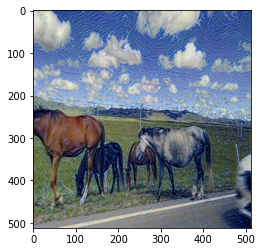

In [ ]:
for i in result:
  # imshow(i)
  image = i.cpu().clone()  # we clone the tensor to not do changes on it
  image = image.squeeze(0)      # remove the fake batch dimension
  image = image.detach().numpy().transpose(1,2,0) 
  image *= 255
  image = np.uint8(image)
  # plt.imshow(image)
  videoWriter.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

videoWriter.release()

In [ ]:
# #save resulting list of frames for future use
# result_np = np.array([x.cpu().detach().numpy() for x in result])
# result_np.shape
# np.save('result_array_sgd.npy', result_np)

## Add temporal loss into video style transfer

In [ ]:
class TemporalLoss(nn.Module):

    def __init__(self, prevImage):
        super(TemporalLoss, self).__init__()
        self.prev_style = gram_matrix(prevImage).detach()
        self.prev_img = prevImage

    def forward(self, input, w1 = 0.5, w2 = 0.5):
        G = gram_matrix(input)
        self.loss = w1 * F.mse_loss(G, self.prev_style) + w2 * F.mse_loss(self.prev_img, input)
        return input

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
temporal_layers_default = ['conv_4']

def get_style_model_and_losses_with_temporal(cnn, normalization_mean, normalization_std,
                               style_img, content_img, prev_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default,
                               temporal_layers = temporal_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []
    temporal_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
        
        if name in temporal_layers:
            prev_feature = model(prev_img).detach()
            temporal_loss = TemporalLoss(prev_feature)
            model.add_module("temporal_loss_{}".format(i), temporal_loss)
            temporal_losses.append(temporal_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, style_losses, content_losses, temporal_losses

In [ ]:
def run_style_transfer_video_sgd_temporal(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, prev_img, num_steps=500,
                       style_weight=100000, content_weight=10, temporal_weight = 100):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses, temporal_losses = get_style_model_and_losses_with_temporal(cnn,
        normalization_mean, normalization_std, style_img, content_img, prev_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = optim.SGD([input_img], lr=0.1, momentum=0.9)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        # correct the values of updated input image
        with torch.no_grad():
            input_img.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0
        temporal_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        for t1 in temporal_losses:
            temporal_score += t1.loss

        style_score *= style_weight
        content_score *= content_weight
        temporal_score *= temporal_weight

        loss = style_score + content_score + temporal_score
        
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print("run {}:".format(run))
            print('Style Loss : {:4f} Content Loss: {:4f} Temporal Loss: {:4f}'.format(
                style_score.item(), content_score.item(), temporal_score.item()))
            print()


        optimizer.step()

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [ ]:
# #Testing code
# content_img = image_loader('frame.jpg')
# input_img = content_img.clone()
# prev_img = image_loader('frame0.jpg')

# output = run_style_transfer_video_sgd_temporal(cnn, cnn_normalization_mean, cnn_normalization_std,
#                           content_img, style_img, input_img, prev_img)



Building the style transfer model..
Optimizing..


<ipython-input-11-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-11-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 26.025496 Content Loss: 259.141968 Temporal Loss: 83.948364

run [100]:
Style Loss : 21.703768 Content Loss: 259.696686 Temporal Loss: 54.195011

run [150]:
Style Loss : 20.730833 Content Loss: 260.217773 Temporal Loss: 49.294369

run [200]:
Style Loss : 20.204624 Content Loss: 260.467346 Temporal Loss: 47.066177

run [250]:
Style Loss : 19.844997 Content Loss: 260.591309 Temporal Loss: 45.720058

run [300]:
Style Loss : 19.580111 Content Loss: 260.653137 Temporal Loss: 44.806587

run [350]:
Style Loss : 19.377951 Content Loss: 260.663818 Temporal Loss: 44.152771

run [400]:
Style Loss : 19.216270 Content Loss: 260.666748 Temporal Loss: 43.652702

run [450]:
Style Loss : 19.080582 Content Loss: 260.661835 Temporal Loss: 43.261292

run [500]:
Style Loss : 18.971788 Content Loss: 260.646088 Temporal Loss: 42.941822



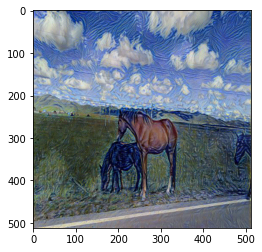

In [ ]:
imshow(output)

Read video as frames and produce transfered video

In [ ]:
cap = cv2.VideoCapture(rawVideo)
frame_cnt = 0
result_temporal = []
count = 0
prev_img = image_loader("frame0.jpg")
while (cap.isOpened() and count <= 300):
  print(f'count: {count}')

  ret, frame = cap.read()
  cv2.imwrite("frame.jpg", frame)
  if not ret: continue
  content_img = image_loader('frame.jpg')
  input_img = content_img.clone()
  output = run_style_transfer_video_sgd_temporal(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, prev_img)
  result_temporal.append(output)
  prev_img = output
  count += 1


count: 0
Building the style transfer model..
Optimizing..


<ipython-input-11-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-11-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Streaming output truncated to the last 5000 lines.
Style Loss : 21.195713 Content Loss: 200.169708 Temporal Loss: 15.456613

run [300]:
Style Loss : 20.975307 Content Loss: 200.093567 Temporal Loss: 15.065440

run [350]:
Style Loss : 20.812664 Content Loss: 200.016968 Temporal Loss: 14.811675

run [400]:
Style Loss : 20.684410 Content Loss: 199.954224 Temporal Loss: 14.614087

run [450]:
Style Loss : 20.582748 Content Loss: 199.893158 Temporal Loss: 14.468779

run [500]:
Style Loss : 20.496187 Content Loss: 199.845123 Temporal Loss: 14.353761

count: 150
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 28.458849 Content Loss: 201.044525 Temporal Loss: 44.964443

run [100]:
Style Loss : 23.036386 Content Loss: 200.021072 Temporal Loss: 20.265898

run [150]:
Style Loss : 22.016661 Content Loss: 199.920990 Temporal Loss: 17.286930

run [200]:
Style Loss : 21.513191 Content Loss: 199.831009 Temporal Loss: 16.116468

run [250]:
Style Loss : 21.195957 Content Loss: 199

In [ ]:
file_path = '.video/result_video_temporal.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # mp4
fps = 20
videoWriter = cv2.VideoWriter(file_path, fourcc, fps, (512, 512))
# videoWriter = cv2.VideoWriter(file_path, fourcc, fps, size)

In [ ]:
for i in result_temporal:
  # imshow(i)
  image = i.cpu().clone()  # we clone the tensor to not do changes on it
  image = image.squeeze(0)      # remove the fake batch dimension
  image = image.detach().numpy().transpose(1,2,0) 
  image *= 255
  image = np.uint8(image)
  plt.imshow(image)
  videoWriter.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
videoWriter.release()

In [ ]:
# #save resulting list
# result_temporal_np = np.array([x.cpu().detach().numpy() for x in result_temporal])
# np.save('data/result_array_temporal_sgd.npy', result_temporal_np)